## Final Project: Politifact Analysis

**GROUP: Forhad Akbar, Adam Douglas, and Soumya Ghosh**

## Project Presentation

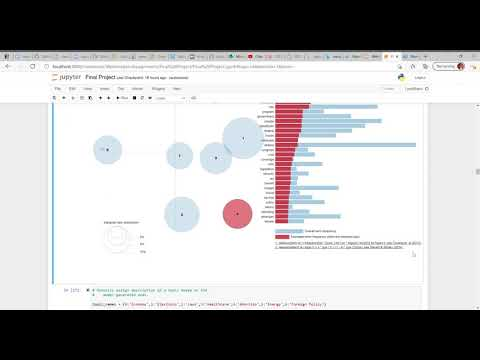

In [98]:
from IPython.display import YouTubeVideo

YouTubeVideo('aSrYKqSAjVs',width=800, height=500)

### Introduction
The website www.politifact.com is a non-partisan fact-checking website that dedicates itself to countering false and misleading political information $^1$. Politifact uses human fact-checkers to research statements made by politicians or viral media that states a political viewpoint. The fact-checker (also known as a "curator") assigns a score for the item: *'True', 'Mostly True', 'Half True', 'Mostly False', 'False'*, and the dreaded "Pants On Fire" for the biggest falsehoods. The specifics of their research are also included to provide detail and sources related to their scoring.



<img src="Image1.png" width=1000 height=1000 />


<img src="Image2.png" width=1000 height=1000 />

### The Data
The data was sourced from the Kaggle web site $^2$ and contains **19,421** records.The content of the data is scrapped from the Politifact site and has various attributes. This list of attributes are covered below:-

**sources:** String representing the person who is associated with the quote.

**sources_dates:** Date on which the information was furnished by the source.

**sourcespostlocation:** The location/medium at which the source furnished the information.

**sources_quote:** The actual quote/information furnished by the source in question.

**curator_name:** Person who curated the information from the source.

**curated_date:** Date at which the curator analyzed and assessed the source's quote.

**fact:** Fact score that is assigned to the source's quote.

**sources_url:** URL of the curator's article about the source's quote.

**curatorsarticletitle:** Title of the article written by the curator to support/reject the source's claim.

**curatorcompletearticle:** Complete blog written by the curator supporting/rejecting the source's claim.


### Goal
The goal of this analysis is to use NLP techniques including tokenization, lemmatization, topic modeling using LDA etc. on the curator's review to categorize the key topics of the record (e.g. budget, coronavirus, election, etc.). Once topics have been assigned to each record, a network analysis of sources will be done to analyze patterns of false information by topic (e.g. politician X frequently puts out more misleading/false information on topic Y than any other).

### Analysis
#### Data Loading and Cleansing

First we will load the data from the CSV file and then prepare the data for analysis.

In [74]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import gensim
import gensim.corpora as corpora
import spacy

import re

import warnings
warnings.filterwarnings('ignore')

In [75]:
pol = pd.read_csv("politifact.csv", index_col = 0, usecols = range(0,11))
pol.head()

,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article
0,Viral image,2021-03-20 00:00:00,a Facebook post:\n,\nSays Disneyland is enforcing a “no scream” p...,Ciara O'Rourke,2021-03-22 00:00:00,false,https://www.politifact.com/factchecks/2021/mar...,"\nNo, Disneyland isn’t enforcing a ‘no scream’...",\nBack in July a Japanese amusement park drew ...
1,Viral image,2021-01-24 00:00:00,a Facebook post:\n,\nVideo “proves 100% that President Joe Biden ...,Ciara O'Rourke,2021-03-22 00:00:00,pants-fire,https://www.politifact.com/factchecks/2021/mar...,"\nNo, this video doesn’t prove Biden isn’t hum...",\nA recent Facebook post uses a video clip of ...
2,Terry McAuliffe,2021-03-10 00:00:00,a speech:\n,\n“If you look at the average teacher pay comp...,Warren Fiske,2021-03-22 00:00:00,true,https://www.politifact.com/factchecks/2021/mar...,\nVa. teachers pay ranks last in U.S. compared...,"\n""If you look at the average teacher pay comp..."
3,TikTok posts,2021-03-17 00:00:00,a video caption:\n,\n“You will need a WHO Yellow Vaccination Pass...,Daniel Funke,2021-03-22 00:00:00,barely-true,https://www.politifact.com/factchecks/2021/mar...,"\nNo, you don’t need a WHO vaccination certifi...",\nA popular TikTok video said that if you want...
4,Mike Bost,2021-03-15 00:00:00,a radio,\nThe American Rescue Plan Act “does not” incl...,Kiannah Sepeda-Miller,2021-03-21 00:00:00,half-true,https://www.politifact.com/factchecks/2021/mar...,\nDoes the American Rescue Plan limit how stat...,\nAfter failing to stop the $1.9 trillion COVI...


In [76]:
# Remove newlines
pol["sources_post_location"] = pol["sources_post_location"].str.replace("\n"," ", regex = False)
pol["sources_quote"] = pol["sources_quote"].str.replace("\n"," ", regex = False)
pol["curators_article_title"] = pol["curators_article_title"].str.replace("\n"," ", regex = False)
pol["curator_complete_article"] = pol["curator_complete_article"].str.replace("\n"," ", regex = False)

pol.head()

,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article
0,Viral image,2021-03-20 00:00:00,a Facebook post:,Says Disneyland is enforcing a “no scream” po...,Ciara O'Rourke,2021-03-22 00:00:00,false,https://www.politifact.com/factchecks/2021/mar...,"No, Disneyland isn’t enforcing a ‘no scream’ ...",Back in July a Japanese amusement park drew a...
1,Viral image,2021-01-24 00:00:00,a Facebook post:,Video “proves 100% that President Joe Biden i...,Ciara O'Rourke,2021-03-22 00:00:00,pants-fire,https://www.politifact.com/factchecks/2021/mar...,"No, this video doesn’t prove Biden isn’t human",A recent Facebook post uses a video clip of a...
2,Terry McAuliffe,2021-03-10 00:00:00,a speech:,“If you look at the average teacher pay compa...,Warren Fiske,2021-03-22 00:00:00,true,https://www.politifact.com/factchecks/2021/mar...,Va. teachers pay ranks last in U.S. compared ...,"""If you look at the average teacher pay compa..."
3,TikTok posts,2021-03-17 00:00:00,a video caption:,“You will need a WHO Yellow Vaccination Passp...,Daniel Funke,2021-03-22 00:00:00,barely-true,https://www.politifact.com/factchecks/2021/mar...,"No, you don’t need a WHO vaccination certific...",A popular TikTok video said that if you want ...
4,Mike Bost,2021-03-15 00:00:00,a radio,The American Rescue Plan Act “does not” inclu...,Kiannah Sepeda-Miller,2021-03-21 00:00:00,half-true,https://www.politifact.com/factchecks/2021/mar...,Does the American Rescue Plan limit how state...,After failing to stop the $1.9 trillion COVID...


In [77]:
pol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19422 entries, 0 to 19421
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   sources                   19422 non-null  object
 1   sources_dates             19099 non-null  object
 2   sources_post_location     19261 non-null  object
 3   sources_quote             19422 non-null  object
 4   curator_name              19400 non-null  object
 5   curated_date              19333 non-null  object
 6   fact                      19422 non-null  object
 7   sources_url               19422 non-null  object
 8   curators_article_title    19417 non-null  object
 9   curator_complete_article  19376 non-null  object
dtypes: object(10)
memory usage: 1.6+ MB


In [78]:
pol.describe()

,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article
count,19422,19099,19261,19422,19400,19333,19422,19422,19417,19376
unique,4395,4378,4437,19396,521,3970,9,19421,19395,19353
top,Facebook posts,2020-11-04 00:00:00,an,On changing the rules for filibusters on pres...,Louis Jacobson,2016-07-21 00:00:00,false,https://www.politifact.com/factchecks/2011/oct...,Milwaukee County executive candidate Chris Ab...,A doppelganger is a ghostly double of a livi...
freq,1250,30,1953,3,1773,19,4556,2,4,4


## Topic Modeling
Topic modeling is an unsupervised machine learning technique that’s capable of scanning a set of textual attributes or documents, detecting word and phrase patterns within them, and automatically clustering word groups and similar expressions that best characterize a set of documents.


### Check the most frequent words in the data
To start our analysis, we wanted to quickly check the words which are most frequently occurring in the Curator's review comments. 

In [79]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([str(text) for text in x])
    all_words = all_words.split()

    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
    return(all_words)
    

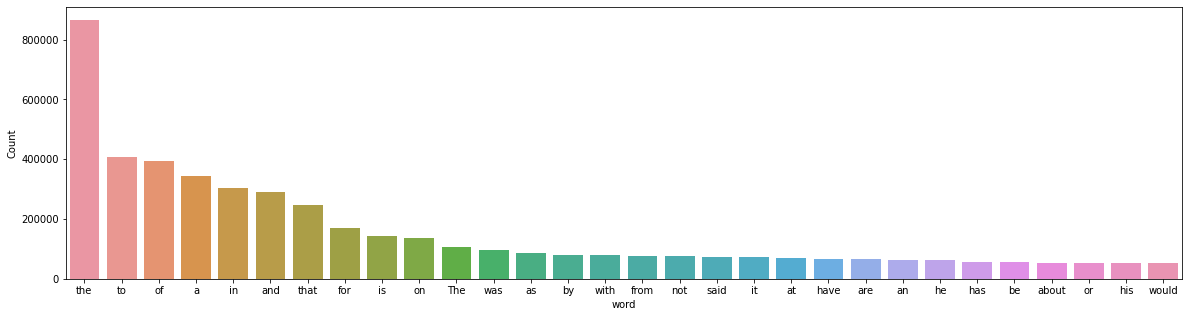

['Back',
 'in',
 'July',
 'a',
 'Japanese',
 'amusement',
 'park',
 'drew',
 'attention',
 'for',
 'encouraging',
 'roller',
 'coaster',
 'riders',
 'to',
 '"please',
 'scream',
 'inside',
 'your',
 'heart."',
 'As',
 'NPR',
 'reported',
 'at',
 'the',
 'time,',
 'the',
 'suggestion',
 'was',
 'one',
 'of',
 'several',
 'recommendations',
 'that',
 'Japanese',
 'amusement',
 'park',
 'operators',
 'released',
 'to',
 'try',
 'to',
 'slow',
 'the',
 'spread',
 'of',
 'COVID-19.',
 'A',
 'recent',
 'post',
 'being',
 'shared',
 'on',
 'social',
 'media',
 'suggests',
 'that',
 'Disneyland',
 'in',
 'California',
 'has',
 'followed',
 'suit.',
 '"New',
 '‘no',
 'scream’',
 'policy',
 'on',
 'roller',
 'coasters,"',
 'reads',
 'one',
 'of',
 'two',
 'bullets',
 'in',
 'what',
 'looks',
 'like',
 'a',
 'local',
 'news',
 'broadcast.',
 '"Disneyland',
 'enforcing',
 'policy."',
 'This',
 'post',
 'was',
 'flagged',
 'as',
 'part',
 'of',
 'Facebook’s',
 'efforts',
 'to',
 'combat',
 'false',

In [80]:
freq_words(pol['curator_complete_article'])

### Text Pre-Processing & Cleansing
Based on the above plot, next we performed some additional preprocessing steps like cleansing, filtering of stopwords, removing single letter words, removing non-alphabatic characters etc.  

In [81]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soumya.ghosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [82]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [83]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [84]:
# Pre-Process Function to clean up the data
def pre_process(text):
    # Remove Special characters like numbers and symbols
    text = re.sub(r'[^a-zA-Z#]',' ', text)
    # Convert text to lower case
    text = text.lower()
    txt_split = text.split(" ")
    # Remove stop words and single letter words
    text = " ".join([w if (len(w)>=2 and w not in stop_words) else "" for w in txt_split])
    return text

Next, we apply all pre-processing steps to *'curator_complete_article'* attribute -

In [87]:
pol['curator_complete_article'] = pol['curator_complete_article'].apply(lambda x: pre_process(str(x)))

Let’s again plot the most frequent words and see if the more significant words have come out.

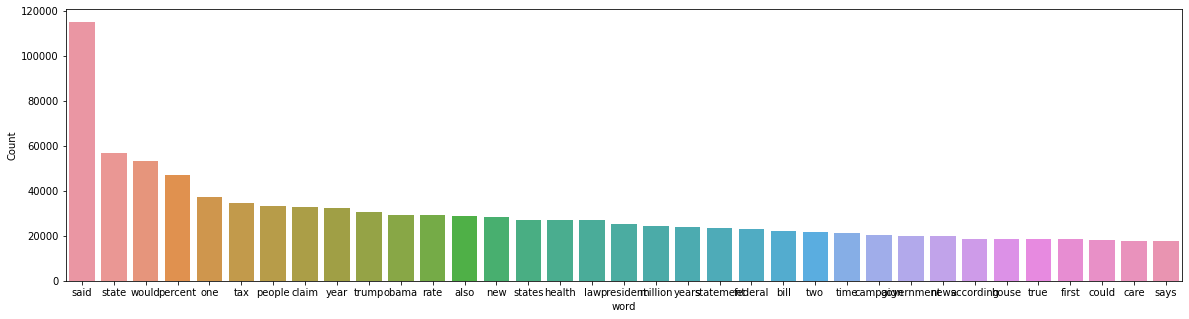

In [88]:
pols = freq_words(pols, 35)

### Lemmatization

To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [14]:
#!python -m spacy download en
#!python -m spacy download en_core_web_sm

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [16]:
tokenized_article = pd.Series(pols).apply(lambda x: x.split())
print(tokenized_article[1])

['recent', 'facebook', 'post', 'uses', 'video', 'clip', 'debate', 'president', 'donald', 'trump', 'joe', 'biden', 'raise', 'suspicions', 'something', 'visible', 'around', 'biden', 'wrist', 'previous', 'social', 'media', 'posts', 'sept', 'debate', 'wrongly', 'said', 'biden', 'wearing', 'wire', 'aid', 'debate', 'footage', 'cast', 'evidence', 'biden', 'human', 'proves', 'president', 'joe', 'biden', 'human', 'description', 'video', 'says', 'someone', 'narrating', 'clip', 'claims', 'something', 'looks', 'like', 'live', 'little', 'serpents', 'emerges', 'biden', 'suit', 'jacket', 'alive', 'narrator', 'says', 'kind', 'looks', 'like', 'shaking', 'head', 'little', 'bit', 'camera', 'pans', 'biden', 'narrator', 'says', 'human', 'people', 'post', 'flagged', 'part', 'facebook', 'efforts', 'combat', 'false', 'news', 'misinformation', 'news', 'feed', 'read', 'partnership', 'facebook', 'clip', 'used', 'facebook', 'video', 'comes', 'mark', 'span', 'video', 'debate', 'debate', 'moderator', 'chris', 'wall

In [17]:
articles_2 = lemmatization(tokenized_article)

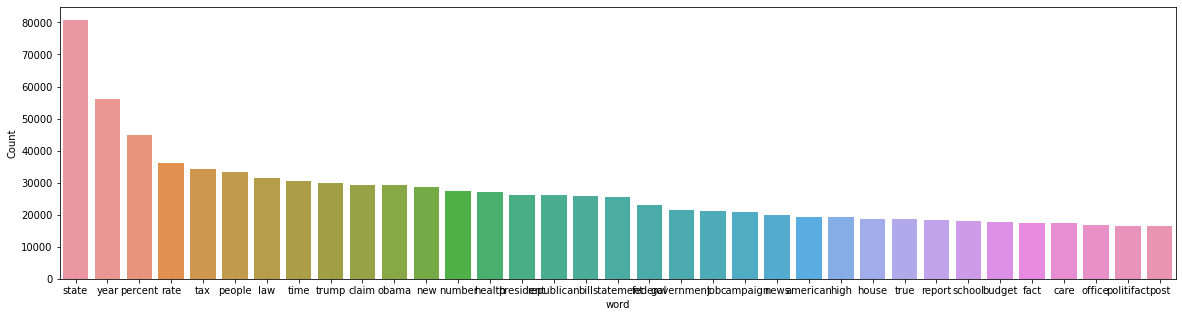

['july',
 'japanese',
 'amusement',
 'park',
 'attention',
 'roller',
 'coaster',
 'rider',
 'heart',
 'npr',
 'time',
 'suggestion',
 'several',
 'recommendation',
 'japanese',
 'amusement',
 'park',
 'operator',
 'slow',
 'spread',
 'covid',
 'recent',
 'post',
 'social',
 'medium',
 'disneyland',
 'california',
 'suit',
 'new',
 'scream',
 'policy',
 'roller',
 'coaster',
 'bullet',
 'local',
 'news',
 'broadcast',
 'disneyland',
 'enforcing',
 'policy',
 'post',
 'flagged',
 'part',
 'facebook',
 'effort',
 'false',
 'news',
 'misinformation',
 'news',
 'feed',
 'partnership',
 'facebook',
 'disneyland',
 'email',
 'politifact',
 'post',
 'march',
 'blog',
 'closed',
 'year',
 'disneyland',
 'park',
 'disneyland',
 'california',
 'adventure',
 'park',
 'planning',
 'reopen',
 'public',
 'april',
 'limited',
 'capacity',
 'operational',
 'change',
 'physical',
 'distancing',
 'follow',
 'guidance',
 'health',
 'authority',
 'post',
 'mention',
 'roller',
 'coaster',
 'exact',
 'news

In [89]:
articles_3 = []
for i in range(len(articles_2)):
    articles_3.append(' '.join(articles_2[i]))

pol['curator_complete_article'] = articles_3

freq_words(pol['curator_complete_article'], 35)

### LDA model
LDA is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

We will start by creating the term dictionary of our corpus, where every unique term is assigned an index

In [19]:
dictionary = corpora.Dictionary(articles_2)

Then we will convert the list of articles (articles_2) into a Document Term Matrix using the dictionary prepared above.

In [20]:
doc_term_matrix = [dictionary.doc2bow(art) for art in articles_2]

It takes a while to run following code chunk

In [21]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [22]:
lda_model.print_topics()

[(0,
  '0.023*"obama" + 0.016*"campaign" + 0.014*"president" + 0.012*"republican" + 0.010*"mccain" + 0.009*"time" + 0.009*"clinton" + 0.008*"trump" + 0.008*"house" + 0.007*"romney"'),
 (1,
  '0.031*"state" + 0.022*"law" + 0.012*"county" + 0.010*"court" + 0.010*"voter" + 0.009*"gun" + 0.008*"election" + 0.008*"florida" + 0.008*"case" + 0.007*"district"'),
 (2,
  '0.015*"state" + 0.014*"country" + 0.014*"united" + 0.014*"obama" + 0.009*"war" + 0.009*"border" + 0.009*"immigration" + 0.009*"immigrant" + 0.009*"military" + 0.008*"american"'),
 (3,
  '0.012*"city" + 0.010*"state" + 0.010*"oil" + 0.009*"company" + 0.009*"energy" + 0.008*"year" + 0.008*"project" + 0.007*"new" + 0.007*"gas" + 0.006*"price"'),
 (4,
  '0.016*"abortion" + 0.014*"woman" + 0.011*"post" + 0.011*"news" + 0.010*"people" + 0.010*"child" + 0.009*"death" + 0.007*"facebook" + 0.007*"life" + 0.007*"story"'),
 (5,
  '0.027*"percent" + 0.024*"tax" + 0.022*"year" + 0.022*"state" + 0.014*"rate" + 0.014*"job" + 0.012*"number" + 

### Topics Visualization
To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [23]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.125144  0.059565       1        1  23.989293
0     -0.042036 -0.149329       2        1  17.386729
1      0.050720  0.005058       3        1  14.096135
6      0.109784 -0.147633       4        1  12.197762
4     -0.245001  0.027684       5        1  11.524385
3      0.049478  0.193139       6        1  10.761672
2     -0.048089  0.011516       7        1  10.044025, topic_info=            Term          Freq         Total Category  logprob  loglift
275          tax  36891.000000  36891.000000  Default  30.0000  30.0000
53        health  28161.000000  28161.000000  Default  29.0000  29.0000
117        state  79482.000000  79482.000000  Default  28.0000  28.0000
468          law  30885.000000  30885.000000  Default  27.0000  27.0000
2114       obama  42468.000000  42468.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
86        people   4112.214429  32150.353090   Topic7  -5.0305   0.2417
448   government   3589.233867  22897.800638   Topic7  -5.1665   0.4451
130         year   4065.060309  57065.281188   Topic7  -5.0420  -0.3436
270    statement   2894.531409  27769.876873   Topic7  -5.3816   0.0371
247       number   2657.474886  27870.999529   Topic7  -5.4671  -0.0520

[535 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
8818       4  0.998366      aarp
30896      3  0.997094     abele
7736       5  0.999965  abortion
1393       3  0.997099  absentee
6579       4  0.997158       aca
...      ...       ...       ...
130        3  0.083781      year
130        4  0.062858      year
130        5  0.039919      year
130        6  0.097222      year
130        7  0.071234      year

[1217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 7, 5, 4, 3])

In [27]:
# Manually assign description of a topic based on the
#    model-generated ones.

topic_names = {0:'Economy',1:'Elections',2:'Laws',3:'Healthcare',4:'Abortion',5:'Energy',6:'Foreign Policy'}

In [28]:
# Assign topic numbers from the model
topics = lda_model.get_document_topics(doc_term_matrix)

nums = [max(t, key = lambda i : i[1])[0] for t in topics]

pol["topic_number"] = nums


## Network Analysis

Next we will look at who is making statements about which topics and evaluate how trustworthy they are.

In [29]:
# Import additional packages
import networkx as nx
from matplotlib import pyplot as plt
from pyvis import network as net

In [30]:
# Truth values to edge weights
truth = {'half-true': 0, 'barely-true': -3, 'mostly-true': 3, 'false': -5, 'true': 5, 'pants-fire': -7}

# We only want the records where the truth is being evaluated, not whether the politician
# flipped their viewpoint.

pol2 = pol[pol['fact'].isin(truth)]

# Create bipartite graph
G = nx.Graph()

for n, t, f in zip(pol2['sources'],pol2['topic_number'],pol2['fact']):
    if n not in G.nodes():
        G.add_node(n, bipartite = 0, color = "firebrick")
    if t not in G.nodes():
        G.add_node(t, bipartite = 1, color = "teal")
    if (n,t) not in G.edges():
        G.add_edge(n,t, weight = truth[f])
    else:
        G[n][t]['weight'] += truth[f]            

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4371
Number of edges: 7893
Average degree:   3.6115


Now that we have our network, let's see who are biggest liars are, and who is the most truthful:

In [31]:
# Top 10 biggest liars

liars = pd.DataFrame(sorted(list(G.degree(weight = 'weight')),key = lambda x: 999999 if x[0] in [0,1,2,3,4,5,6] else(x[1])))

liars.columns = ["Source","Truth Level"]

liars.head(10)

,Source,Truth Level
0,Facebook posts,-4367
1,Viral image,-2281
2,Donald Trump,-2146
3,Bloggers,-1876
4,Chain email,-434
5,Joe Biden,-355
6,Ted Cruz,-252
7,Instagram posts,-249
8,Tweets,-177
9,Newt Gingrich,-176


In [32]:
# Top 10 most truthful

truth = pd.DataFrame(sorted(list(G.degree(weight = 'weight')),reverse = True, key = lambda x: x[1]))

truth.columns = ["Source","Truth Level"]

truth.head(10)

,Source,Truth Level
0,Hillary Clinton,60
1,Sheldon Whitehouse,43
2,Charlie Crist,26
3,Lincoln Chafee,26
4,Pam Bondi,24
5,Paul Krugman,23
6,Stephen Colbert,23
7,Edward Lindsey,23
8,Matthew Dowd,22
9,Leonard Lance,21


Next we look at who had the most egregious of lies, the dreaded "Pants On Fire" rating.

In [33]:
# Who had the most "pants on fire" statements?

fire = pol.loc[pol['fact'] == 'pants-fire']

fire['sources'].value_counts().head(10)

Facebook posts     266
Bloggers           180
Donald Trump       149
Viral image        134
Chain email         45
Barack Obama        36
Scott Walker        20
Joe Biden           20
Mitt Romney         17
Hillary Clinton     16
Name: sources, dtype: int64

Some surprising results, I have to say.

Now to visualization...we can visualize the entire network, but as you can see, it is quite busy!

In [34]:
# Visualize entire network

n = net.Network(height = "1000px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - People & Statements', directed = False)
nx_graph = nx.Graph(G)
n.from_nx(nx_graph)
n.show_buttons(filter_=['physics'])
n.show("politifact1.html")

### Most Truthful People and their Topics

We can now look at the people who are the most truthful about their topics. We'll use a cut-off value of 10 or higher to include someone in this subnetwork. This means that the person's statements about a topic have to be reasonably truthful in aggregate.

In [37]:
# Truthful people and topics

H = nx.Graph()

for u,v,d in G.edges(data=True):
    if int(d['weight']) > 10:
        if u not in H.nodes():
            H.add_node(u)
        if v not in H.nodes():
            H.add_node(v)
        H.add_edge(u,v,value=d['weight'])
        
print(nx.info(H))
        
n2 = net.Network(height = "1000px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Truthful Statements', directed = False)

n2.from_nx(nx.Graph(H))
n2.show_buttons(filter_=['physics'])
n2.show("politifact2.html")

Name: 
Type: Graph
Number of nodes: 63
Number of edges: 67
Average degree:   2.1270


Interestingly, Hillary Clinton has a really large truth value when it comes to topic 5.

Next we'll look at the opposite, people who are generally untruthful with their statements about certain topics.

### Least Truthful People and Their Topics

In [38]:
# Least truthful people and topics

H = nx.Graph()

for u,v,d in G.edges(data=True):
    if int(d['weight']) < -10:
        if u not in H.nodes():
            H.add_node(u)
        if v not in H.nodes():
            H.add_node(v)
        H.add_edge(u,v,value=d['weight'])
        
print(nx.info(H))
        
n3 = net.Network(height = "1000px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Untruthful Statements', directed = False)

n3.from_nx(nx.Graph(H))
n3.show_buttons(filter_=['physics'])
n3.show("politifact3.html")

Name: 
Type: Graph
Number of nodes: 257
Number of edges: 426
Average degree:   3.3152


Wow! The opposite side is quite busy! However, that may be a function of the dataset we are looking at. After all, one would expect a political fact-checking site to concentrate more on false statements than they do on true ones.

We'll increase the threshold a bit and see if we can get a clearer visualization.

In [52]:
# Least truthful people and topics, part deux

H = nx.Graph()

for u,v,d in G.edges(data=True):
    if int(d['weight']) < -40:
        if u not in H.nodes():
            H.add_node(u)
        if v not in H.nodes():
            H.add_node(v)
        H.add_edge(u,v,value=abs(d['weight']))
        
print(nx.info(H))
        
n4 = net.Network(height = "700px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Untruthful Statements', directed = False)

n4.from_nx(nx.Graph(H))
n4.show_buttons(filter_=['physics'])
n4.show("politifact4.html")

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 54
Average degree:   4.5000


There are some surprising names shown here.

### Topics 0 and 1 - Most and Least Trusted

In [90]:
# Topic 0 and 1 Most Trusted

H = nx.Graph()

H.add_node(0)
H.add_node(1)

for u,v,d in G.edges(data=True):
    if u in [0,1] or v in [0,1]:
        if d['weight'] > 10:
            H.add_edge(u,v,value=d['weight'])
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n5 = net.Network(height = "700px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Most Truthful for Topics 0 & 1 (Economy & Elections)', directed = False)

n5.from_nx(nx.Graph(H))
n5.show_buttons(filter_=['physics'])
n5.show("politifact5.html")

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 16
Average degree:   1.8824


In [91]:
# Topic 0 and 1 Least Trusted

H = nx.Graph()

H.add_node(0)

for u,v,d in G.edges(data=True):
    if u in [0,1] or v in [0,1]:
        if d['weight'] < -40:
            H.add_edge(u,v,value=abs(d['weight']))
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n6 = net.Network(height = "600px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Least Truthful for Topics 0 & 1 (Economy & Elections)', directed = False)

n6.from_nx(nx.Graph(H))
n6.show_buttons(filter_=['physics'])
n6.show("politifact6.html")

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 16
Average degree:   2.4615


### Topics 2 and 3 - Most and Least Trusted

In [92]:
# Topic 2 and 3 Most Trusted

H = nx.Graph()

H.add_node(2)
H.add_node(3)

for u,v,d in G.edges(data=True):
    if u in [2,3] or v in [2,3]:
        if d['weight'] > 10:
            H.add_edge(u,v,value=d['weight'])
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n7 = net.Network(height = "600px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Most Truthful for Topics 2 & 3 (Laws & Healthcare)', directed = False)

n7.from_nx(nx.Graph(H))
n7.show_buttons(filter_=['physics'])
n7.show("politifact7.html")

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 14
Average degree:   1.7500


In [93]:
# Topic 2 and 3 Least Trusted

H = nx.Graph()

H.add_node(2)
H.add_node(3)

for u,v,d in G.edges(data=True):
    if u in [2,3] or v in [2,3]:
        if d['weight'] < -30:
            H.add_edge(u,v,value=abs(d['weight']))
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n8 = net.Network(height = "500px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Least Truthful for Topics 2 & 3 (Laws & Healthcare)', directed = False)

n8.from_nx(nx.Graph(H))
n8.show_buttons(filter_=['physics'])
n8.show("politifact8.html")

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 14
Average degree:   2.3333


### Topics 4 and 5 - Most and Least Trusted

In [94]:
# Topic 4 and 5 Most Trusted

H = nx.Graph()

H.add_node(4)
H.add_node(5)

for u,v,d in G.edges(data=True):
    if u in [4,5] or v in [4,5]:
        if d['weight'] > 10:
            H.add_edge(u,v,value=d['weight'])
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n9 = net.Network(height = "700px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Most Truthful for Topics 4 & 5 (Abortion & Energy)', directed = False)

n9.from_nx(nx.Graph(H))
n9.show_buttons(filter_=['physics'])
n9.show("politifact9.html")

Name: 
Type: Graph
Number of nodes: 33
Number of edges: 31
Average degree:   1.8788


In [95]:
# Topic 4 and 5 Least Trusted

H = nx.Graph()

H.add_node(4)
H.add_node(5)

for u,v,d in G.edges(data=True):
    if u in [4,5] or v in [4,5]:
        if d['weight'] < -30:
            H.add_edge(u,v,value=abs(d['weight']))
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n10 = net.Network(height = "1000px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Least Truthful for Topics 4 & 5 (Abortion & Energy)', directed = False)

n10.from_nx(nx.Graph(H))
n10.show_buttons(filter_=['physics'])
n10.show("politifact10.html")

Name: 
Type: Graph
Number of nodes: 27
Number of edges: 33
Average degree:   2.4444


### Topic 6 - Most and Least Trusted

In [96]:
# Topic 6 Most Trusted

H = nx.Graph()

H.add_node(6)

for u,v,d in G.edges(data=True):
    if u == 6 or v == 6:
        if d['weight'] > 10:
            H.add_edge(u,v,value=d['weight'])
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n11 = net.Network(height = "500px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Most Truthful for Topic 6 (Foreign Policy)', directed = False)

n11.from_nx(nx.Graph(H))
n11.show_buttons(filter_=['physics'])
n11.show("politifact11.html")

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 6
Average degree:   1.7143


In [97]:
# Topic 6 Least Trusted

H = nx.Graph()

H.add_node(6)

for u,v,d in G.edges(data=True):
    if u == 6 or v == 6:
        if d['weight'] < -30:
            H.add_edge(u,v,value=abs(d['weight']))
            if u not in H.nodes():
                H.add_node(u)
            if v not in H.nodes():
                H.add_node(v)
        
        
print(nx.info(H))
        
n12 = net.Network(height = "500px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Politifact - Least Truthful for Topic 6 (Foreign Policy)', directed = False)

n12.from_nx(nx.Graph(H))
n12.show_buttons(filter_=['physics'])
n12.show("politifact12.html")

Name: 
Type: Graph
Number of nodes: 9
Number of edges: 8
Average degree:   1.7778


### Works Cited
1 - https://www.politifact.com/who-pays-for-politifact/

2 - https://www.kaggle.com/shivkumarganesh/politifact-factcheck-data